*Check the location distribution of different disease*

In [1]:
import pandas as pd
import torchio as tio
import os
import copy
import torch
import ast
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
import SimpleITK as sitk

location_csv = pd.read_csv('./new_location.csv',header=0)
pathology = location_csv.columns.tolist()
print(pathology)

views = ['coronal','sagittal','transversal']

['StudyUID', 'ACL', 'Meniscus', 'bakerzyste', 'Femuropatellargelenks Dysplasie-Hypoplasie', 'Einklemmung-Plica med.', 'Einklemmung-Hoffa FK', 'Innenmeniskus-Extrusion/Luxation und Außenmeniskus-Extrusion/Luxation', 'Synovia-Erguß', 'Femur-Oedem', 'Synovia-Bakerzysten-/Kapselruptur', 'Außenband-Signalanhebung', 'Innenband-Signalanhebung', 'Femur-Fraktur/Fissur']


*Find out how many cases have this specific pathology*

In [2]:
def case_name(disease_num): # should be int but couldn't be 0
    location_csv_pathology = location_csv[~location_csv[pathology[disease_num]].isnull()]
    names = location_csv_pathology['StudyUID'].tolist()
    return names

*Find out where is the real location for each cases*

In [3]:
def pixel_location(view,names,disease_num):
    pixel_locations = []
    for name in names:
        location_label = location_csv.loc[location_csv['StudyUID'] == name][pathology[disease_num]].tolist()
        root_path = './previous_dataset/Preprocessed_dataset_2'
        study_path = os.path.join(root_path, name, f'{view.upper()}_PROTON.nii')
        img = tio.ScalarImage(study_path)
        physical_location = ast.literal_eval(location_label[0])
        sitk_img = img.as_sitk()
        pixel_location = sitk_img.TransformPhysicalPointToIndex(physical_location)
        pixel_locations.append(pixel_location)

    return pixel_locations

In [4]:
# Given a tensor of shape height, width, depth, plot each depth slice in a grid
def plot_slices(tensor, title=None):
	tensor = tensor.squeeze()
	n_slices = tensor.shape[2]
	n_rows = int(n_slices / 4)
	fig, axes = plt.subplots(nrows=n_rows, ncols=4, figsize=(20, 20))
	plt.axis('off')
	for i, ax in enumerate(axes.flatten()):
		if i < n_slices:
			ax.imshow(tensor[:, :, i], cmap='gray')
			ax.set_title(f'Slice {i}')
		else:
			ax.axis('off')
	if title:
		fig.suptitle(title, fontsize=16)
	plt.show()

In [5]:
import torchio as tio

disease_num = 1
view = "sagittal"
names = case_name(disease_num)

location_label = location_csv.loc[location_csv['StudyUID'] == names[0]][pathology[disease_num]].tolist()
root_path = './previous_dataset/Preprocessed_dataset_2'
study_path = os.path.join(root_path, names[0], f'{view.upper()}_PROTON.nii')
img = tio.ScalarImage(study_path)#.data
#plot_slices(img.copy())

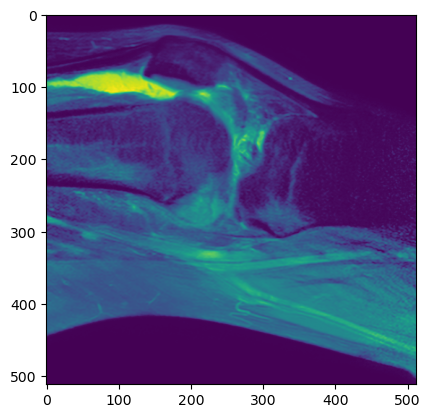

In [6]:
plt.imshow(img.data[0, ..., 15])

In [7]:
x = sitk.GetArrayFromImage(img.as_sitk())
print(x.shape)

(27, 512, 512)


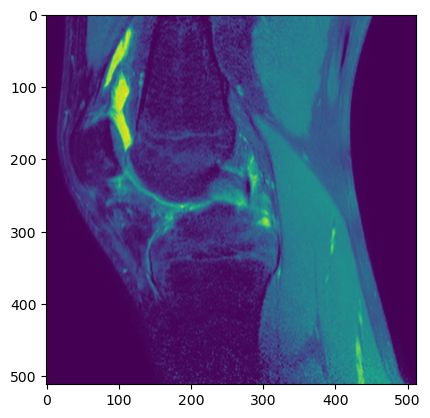

In [8]:
plt.imshow(sitk.GetArrayFromImage(img.as_sitk())[10])

*This step has been done in the code*

In [ ]:
i = 1 # 0 is the index
while i < len(pathology):
    dictionary = {}
    for view in views:
        dictionary[view] = pixel_location(view,case_name(i),i)       
    df = pd.DataFrame(dictionary)
    df.to_csv(f"./{pathology[i]}_location.csv",index=False)
    i += 1

*Read the csv file for different diseases*

In [1]:
import pandas as pd
import os
import ast
import seaborn as sns
import matplotlib.pyplot as plt

location_csv = pd.read_csv('./new_data/grouped_location.csv',header=0)
pathology = location_csv.columns.tolist()
print(pathology)
views = ['coronal','sagittal','transversal']

def read_csv(view,disease_num):
    df = pd.read_csv(f"./previous_dataset/src_mask/location_diseases/disease{disease_num}_location.csv")
    datas = df[view].tolist()
    datas = [ast.literal_eval(x) for x in datas]

    x_value = []
    y_value = []
    z_value = []
    for data in datas:
        x_value.append(data[0])
        y_value.append(data[1])
        z_value.append(data[2])
    
    dictionary = {
        'x_value': x_value,
        'y_value': y_value,
        'z_value': z_value
    }

    df = pd.DataFrame(dictionary)
    return df

['StudyUID', 'ACL', 'PCL', 'Inner_Meniscus', 'Outer_Meniscus']


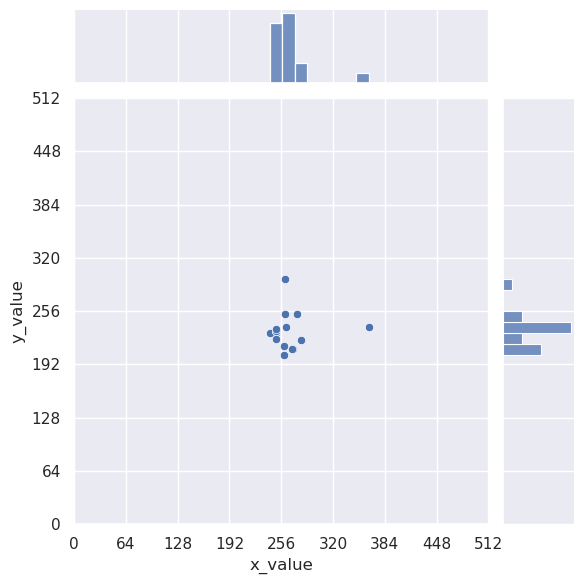

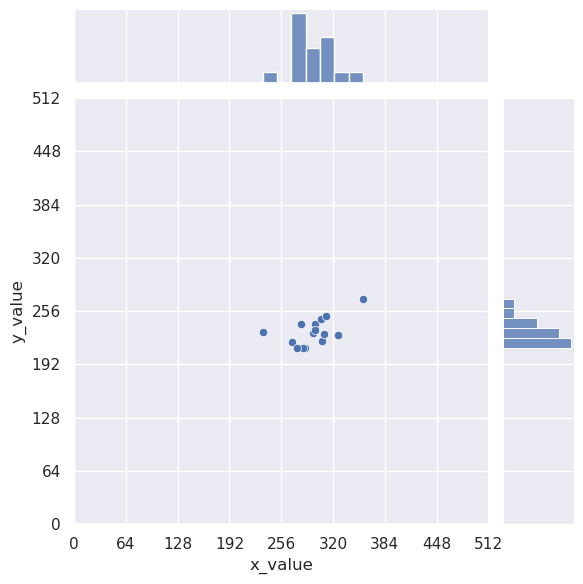

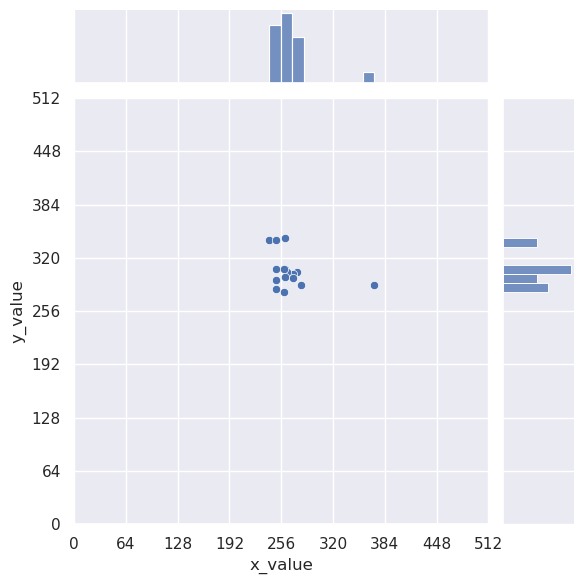

In [3]:
disease_num = 2 # 7, 10, 11, 12, 13

sns.set_theme()
kind = 'scatter' # 'scatter', 'hist', 'hex', 'kde', 'reg', 'resid'

for view in views:
    img = sns.jointplot(x="x_value", y="y_value", data=read_csv(view,disease_num), kind=kind, xlim=(0,512),ylim=(0,512))
    plt.gca().set_xticks([x for x in range(0, 512+1, 64)])
    plt.gca().set_yticks([x for x in range(0, 512+1, 64)])
    # img.fig.suptitle(f"{view} location of {pathology[disease_num]}")

In [4]:
# Calculate the area location, use the middle value
def middle_value(lst):
    middle_index = len(lst) // 2  # integer division to get the middle index
    middle_value = lst[middle_index]

    # So we don't need to pad at last
    if middle_value-128 < 0:
        middle_value = 128
    elif middle_value+128 > 512:
        middle_value = 512-128
    return middle_value

def area(view,disease_num):
    x_value = sorted(read_csv(view,disease_num)['x_value'].tolist())
    x_middle = middle_value(x_value)
    y_value = sorted(read_csv(view,disease_num)['y_value'].tolist())
    y_middle = middle_value(y_value)
    
    print(f"The area in {view} is:" 
        f"\nx:[{x_middle-128},{x_middle+128}]"
        f"\ny:[{y_middle-128},{y_middle+128}]")
    
    return x_middle, y_middle

for view in views:
    x_middle, y_middle = area(view=view,disease_num=disease_num)

The area in coronal is:
x:[130,386]
y:[106,362]
The area in sagittal is:
x:[134,390]
y:[103,359]
The area in transversal is:
x:[132,388]
y:[144,400]


In [12]:
import torch

view = "sagittal"
disease_num = 2
x_middle, y_middle = area(view=view,disease_num=disease_num)

# Create the original tensor
tensor_original = torch.randn(512, 512, 25)

# Do the central crop
tensor_cropped = tensor_original[x_middle-128:x_middle+128, y_middle-128:y_middle+128, :]

# Check the shape of the cropped tensor
print(tensor_cropped.shape)

The area in sagittal is:
x:[167,423]
y:[138,394]
torch.Size([256, 256, 25])


In [15]:
import torch
import numpy as np
from scipy.ndimage import zoom
import SimpleITK as sitk

def preprocess_data(case_path, transform=None):
    img = sitk.ReadImage(case_path)
    series = sitk.GetArrayFromImage(img).astype(np.float32)
    # series = series[9:17,128:384,128:384] # crop to 256
    series = zoom(series, (1,0.4375,0.4375)) # shrimp to 224: (1,0.4375,0.4375)
    series = torch.tensor(np.stack((series,)*3, axis=0))
    
    series = series.permute(1, 0, 2, 3)

    if transform is not None:
        for i, slice in enumerate(series.split(1)):
            series[i] = transform(slice.squeeze())

    return series

dataset_dir = "./previous_dataset/Preprocessed_dataset_2/1.2.840.113619.6.95.31.0.3.4.1.3096.13.100076/SAGITTAL_PROTON.nii"
series = preprocess_data(dataset_dir)
slice_num = series.shape[0]
series = series.to("cuda")
print(slice_num)

22


In [21]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to("cuda")

with torch.no_grad():
    features_dict = model.forward_features(series)
    features = features_dict['x_norm_patchtokens']
    print(features.shape)

Using cache found in /home/domainHomes/tian/.cache/torch/hub/facebookresearch_dinov2_main


torch.Size([22, 256, 768])


In [22]:
from sklearn.decomposition import PCA

patch_h = patch_w = 16 # 448/14=32
features = features.reshape(slice_num * patch_h * patch_w, 768)
features = features.cpu().detach()
pca = PCA(n_components=3)
pca.fit(features)
pca_features = pca.transform(features)

pca_features_bg = pca_features[:, 0] < 0
pca_features_fg = ~pca_features_bg
print(pca_features_fg.shape)

mask = pca_features_bg.reshape(slice_num,patch_h,patch_w)
print(mask.shape)

(5632,)
(22, 16, 16)


In [37]:
output_shape = (slice_num,256,256)
output_tensor = torch.nn.functional.interpolate(
    torch.from_numpy(mask.astype(np.float32)).unsqueeze(0).unsqueeze(0), size=(slice_num,256,256), mode='trilinear', align_corners=False
    )[0].squeeze(0)
print(output_tensor.shape)
print(output_tensor)

torch.Size([22, 256, 256])
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 

In [25]:
import torch
import torch.nn.functional as F

# Assuming you have a tensor with shape (22, 16, 16)
input_tensor = torch.randn(22, 16, 16)

# Define the desired output shape
output_shape = (22, 256, 256)

# Use interpolate function to resize the tensor
output_tensor = F.interpolate(input_tensor, size=output_shape[1:], mode='bilinear', align_corners=False)

# Verify the shape of the output tensor
print(output_tensor.shape)  # Output: torch.Size([22, 256, 256])


ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [16] and output size of (256, 256). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.